In [1]:
# Colab Setup
# If running in Google Colab, install the required library.
!pip install -q -Uqq nixtla
!pip install -q dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 2.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import time
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

In [3]:
# Initialize the NixtlaClient with your API key
# Replace 'your_api_key' with your actual Nixtla API key.
from google.colab import userdata
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')
nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)

In [4]:
# Load the dataset
# Energy consumption dataset from PJM Hourly Energy Consumption dataset.
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])



In [5]:
# Display the first few rows of the dataset
df.head()



,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
2,AP-AP,2023-10-01 06:00:00+00:00,3734.200
3,AP-AP,2023-10-01 07:00:00+00:00,3687.402
4,AP-AP,2023-10-01 08:00:00+00:00,3679.819


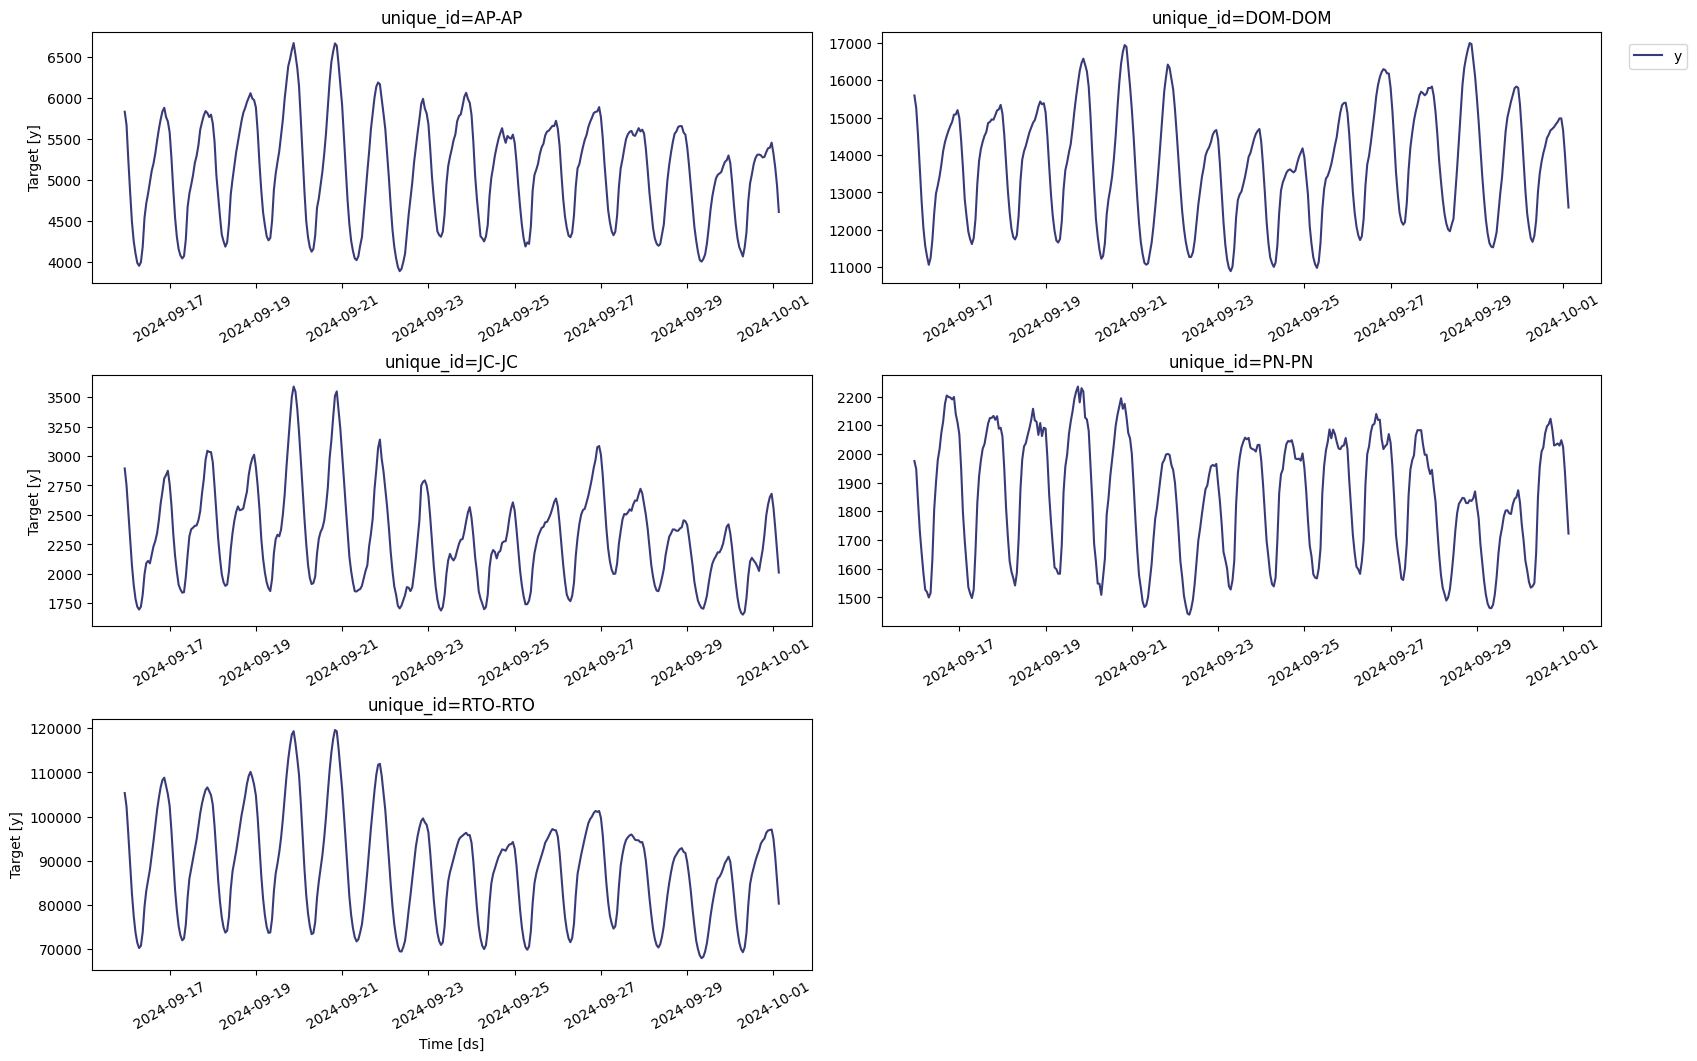

In [6]:
# Plot the time series data
nixtla_client.plot(df, max_insample_length=365)



In [7]:
# Split data into training and test sets
# Reserve the last 96 time steps for the test set and create an input DataFrame
horizon = 96
input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)
test_df = df.groupby('unique_id').tail(horizon)



<ipython-input-7-de4cf67498a6>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)


In [8]:
# Forecast using TimeGPT
# Fine-tune the model with MAE loss and use the long-horizon model
start = time.time()
fcst_df = nixtla_client.forecast(
    df=input_df,
    h=horizon,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)
end = time.time()
timegpt_duration = end - start
print(f"Time (TimeGPT): {timegpt_duration} seconds")



Time (TimeGPT): 4.005400657653809 seconds


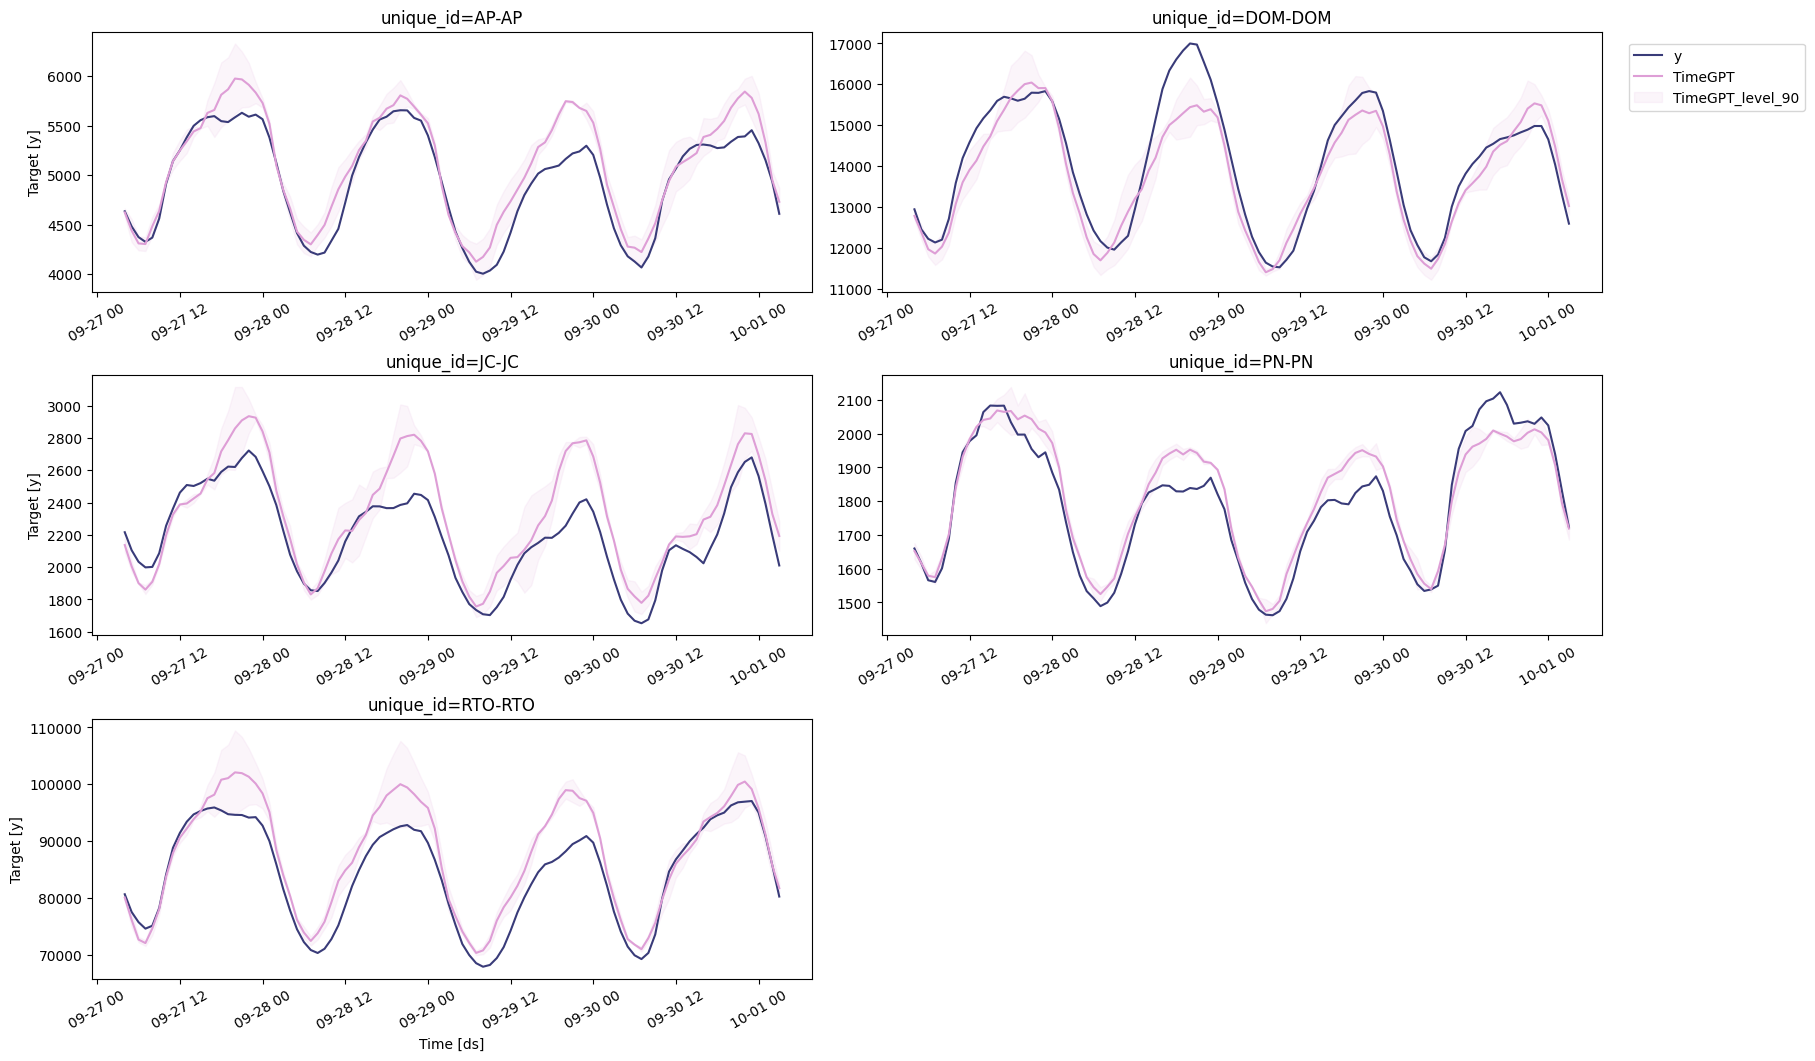

In [9]:
# Plot the predictions against the actual values
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')



In [10]:
# Evaluate the model's performance
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])
test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)



In [11]:
# Display average metrics
average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
print(average_metrics)



metric
mae      882.638598
smape      0.019971
Name: TimeGPT, dtype: float64
